<a href="https://colab.research.google.com/github/samueleancora/CV2022-AncoraTamborrino/blob/master/AncoraTamborrino_Project_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision Project by Ancora Samuele and Tamborrino Michele**

The project aims to develop a Neural Network to classify several number of species of fishes, giving also additional pieces of information such as the depth in which they live.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os

Mount the drive to obtain the dataset.

In [2]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [3]:
zip_ref = zipfile.ZipFile('mydrive/MyDrive/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Function to handle strings with ease.

In [4]:
def join_tuple_string(strings_tuple) -> str:
    return ' '.join(strings_tuple)

Finally we can start.

### **General settings**

In [5]:
# Selected one of the three directory in order to single taking each species
image_dir = Path('/tmp/Fish_Data/images/cropped')
print("Image dir:" + str(image_dir))

# Take all the objects that have anything in the name and ends with .png
filepaths = list(image_dir.glob(r'**/*.png'))

# Uses join_tuple_string that takes as argument the list of the tuples containing the species's name
labels = list(map(join_tuple_string, list(map(lambda x: os.path.split(x)[1].split("_", 2)[:2], filepaths))))
print("I found " + str(len(labels)) + " elements.")

# Creates a sort of column in a table
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenates previous columns providing a data frame.
image_df = pd.concat([filepaths, labels], axis=1)

###############################################################################################
# This may be useful in order to take out from the labeling the images with unwanted names.   #
# Since we have a small number (~40) images called like CUNWCB, we may think to drop them.    #
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-3:] == 'png' else x)  #
image_df = image_df.dropna(axis=0)  #
# print(image_df)                                                                             #
###############################################################################################

# Let's read the csv with the depth labels for species
dfd = pd.read_csv("/content/mydrive/MyDrive/dummylabel.csv", sep=';')
print(dfd)

# Join the two dataframes based on the column Label
image_df = pd.merge(image_df, dfd, on='Label')

# Drop duplicates based on the columns Label and Deep, a drop based on ID would not affect anything
image_df = image_df.drop_duplicates(['Label', 'Deep'])
print(image_df)

# Save as csv just for debugging controls
image_df.to_csv('new.csv', sep='\t')

samples = []

for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(20, random_state=1, replace=True))

image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(image_df)

# We may look at the numbers for each species
print(image_df['Label'].value_counts())

# Create the train and test set
train_df, test_df = train_test_split(image_df, train_size=0.6, shuffle=True, random_state=3)

# This process helps us to not run out of memory, loading an image per time
# This is responsible for image augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

print(test_images)

# We will use a pre trained model, which is MobileNetV2 transfer CNN model.
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights='imagenet',
                                                     pooling='avg'
                                                     )
#
pretrained_model.trainable = False

# By doing this we are able to take the first input layer
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(479, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

Image dir:/tmp/Fish_Data/images/cropped
I found 4414 elements.
                             Label      Deep
0           acanthaluteres brownii   0-100 m
1    acanthaluteres spilomelanurus  demersal
2          acanthaluteres vittiger   0-100 m
3             acanthistius cinctus   0-100 m
4          acanthopagrus australis  demersal
..                             ...       ...
507        wetmorella albofasciata       7 m
508        wetmorella nigropinnata       7 m
509             xiphocheilus typus       7 m
510          zenarchopterus dispar       7 m
511                     zeus faber       7 m

[512 rows x 2 columns]
                                               Filepath  \
0     /tmp/Fish_Data/images/cropped/carcharhinus_gal...   
9     /tmp/Fish_Data/images/cropped/wetmorella_nigro...   
21    /tmp/Fish_Data/images/cropped/sphyraena_forste...   
31    /tmp/Fish_Data/images/cropped/epinephelus_merr...   
46    /tmp/Fish_Data/images/cropped/pervagor_janthin...   
...                

### **Model compile and fit**

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/8
130/130 [==============================] - 155s 1s/step - loss: 5.9160 - accuracy: 0.0215 - val_loss: 5.0548 - val_accuracy: 0.1015
Epoch 2/8
130/130 [==============================] - 152s 1s/step - loss: 3.4742 - accuracy: 0.2957 - val_loss: 2.8333 - val_accuracy: 0.4052
Epoch 3/8
130/130 [==============================] - 154s 1s/step - loss: 1.7179 - accuracy: 0.6014 - val_loss: 2.0437 - val_accuracy: 0.5629
Epoch 4/8
130/130 [==============================] - 158s 1s/step - loss: 0.9596 - accuracy: 0.7690 - val_loss: 1.6284 - val_accuracy: 0.6509
Epoch 5/8
130/130 [==============================] - 182s 1s/step - loss: 0.5755 - accuracy: 0.8599 - val_loss: 1.4632 - val_accuracy: 0.7012
Epoch 6/8
130/130 [==============================] - 156s 1s/step - loss: 0.3405 - accuracy: 0.9249 - val_loss: 1.3399 - val_accuracy: 0.7389
Epoch 7/8
130/130 [==============================] - 154s 1s/step - loss: 0.2138 - accuracy: 0.9584 - val_loss: 1.3339 - val_accuracy: 0.7602
Epoch 

### **Plotting metrics**





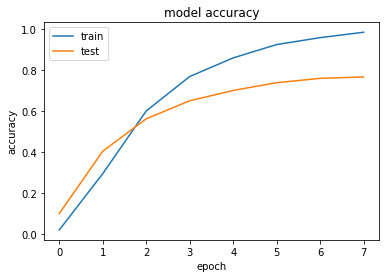

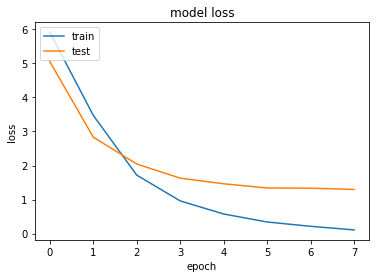

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('mydrive/MyDrive/plots/model_accuracy.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('mydrive/MyDrive/plots/model_loss.png')
plt.show()

### **Model evaluation**

In [ ]:
result = model.evaluate(test_images, verbose=0)
print("    Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}%".format(result[1] * 100))

    Test loss: 1.42709
Test accuracy: 74.69%


### **Predict species**

In [ ]:
test_images.reset()
pred = model.predict(test_images, verbose=0)

predicted_class_indices = np.argmax(pred, axis=1)

labels = train_images.class_indices
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print("I found " + str(len(labels)) + " labels.")
print("I found " + str(len(predictions)) + " predictions.")

I found 479 labels.
I found 3449 predictions.


### **Save results into a .csv file**

In [ ]:
filenames = test_images.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})
results.to_csv('mydrive/MyDrive/results/results.csv', index=False)